# 42. ITQ再学習必要性検証

## 目的
- E5-largeで学習したITQを他のモデル/ライブラリに適用した場合の性能検証
- 再学習なしで許容範囲内のRecallが出るか確認

## 仮説
- 同じモデル (multilingual-e5-large) ならば、ライブラリが異なっても埋め込み空間は類似
- ITQのCentering (平均ベクトル) が類似していれば、再学習なしで適用可能

## 検証パターン
1. **ベースライン**: ST E5-large + 学習済みITQ
2. **fastembed E5**: 同じモデル、異なるライブラリ
3. **fastembed BGE**: 異なるモデル（参考）

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from tqdm import tqdm
import time

from fastembed import TextEmbedding
from sentence_transformers import SentenceTransformer
from src.itq_lsh import ITQLSH

print('Setup complete')

Setup complete


In [3]:
# 定数設定
ITQ_MODEL_PATH = '../data/itq_model.pkl'
DB_PATH = '../data/experiment_400k.duckdb'
N_SAMPLES = 2000
CANDIDATE_SIZES = [100, 200, 500, 1000, 2000]
TOP_K = 10
N_QUERIES = 100
SEED = 42

## 1. データ準備

In [4]:
# experiment_400kからサンプリング
conn = duckdb.connect(DB_PATH, read_only=True)

# ランダムサンプリング (シード固定)
df_sample = conn.execute(f'''
    SELECT id, text, lang, embedding
    FROM documents
    ORDER BY hash(id + {SEED})
    LIMIT {N_SAMPLES}
''').fetchdf()

texts = df_sample['text'].tolist()
existing_embeddings = np.array(df_sample['embedding'].tolist()).astype(np.float32)

print(f'テストテキスト数: {len(texts)}')
print(f'既存埋め込み shape: {existing_embeddings.shape}')

conn.close()

テストテキスト数: 2000
既存埋め込み shape: (2000, 1024)


## 2. 各ライブラリ/モデルで埋め込み生成

In [5]:
# sentence-transformers E5-large (ベースライン・GPU)
print('sentence-transformers E5-large (GPU) をロード中...')
st_model = SentenceTransformer('intfloat/multilingual-e5-large', device='cuda')

texts_with_prefix = [f'passage: {t}' for t in texts]
st_embeddings = st_model.encode(
    texts_with_prefix,
    normalize_embeddings=False,
    show_progress_bar=True
).astype(np.float32)

print(f'ST E5: {st_embeddings.shape}')

sentence-transformers E5-large (GPU) をロード中...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

ST E5: (2000, 1024)


In [6]:
# fastembed E5-large
print('fastembed E5-large (CPU) をロード中...')
fe_e5 = TextEmbedding("intfloat/multilingual-e5-large")
fe_embeddings = np.array(list(fe_e5.embed(texts))).astype(np.float32)
print(f'fastembed E5: {fe_embeddings.shape}')

fastembed E5-large (CPU) をロード中...


/tmp/ipykernel_3114543/591718788.py:3: UserWarning: The model intfloat/multilingual-e5-large now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  fe_e5 = TextEmbedding("intfloat/multilingual-e5-large")


fastembed E5: (2000, 1024)


In [7]:
# fastembed BGE-large (異なるモデル、参考用)
bge_embeddings = None
try:
    print('fastembed BGE-large (CPU) をロード中...')
    fe_bge = TextEmbedding("BAAI/bge-large-en-v1.5")
    bge_embeddings = np.array(list(fe_bge.embed(texts))).astype(np.float32)
    print(f'fastembed BGE: {bge_embeddings.shape}')
except Exception as e:
    print(f'BGE-large ロード失敗: {e}')

fastembed BGE-large (CPU) をロード中...
fastembed BGE: (2000, 1024)


## 3. ITQモデル読み込みと平均ベクトル比較

In [8]:
# ITQモデル読み込み
print('ITQモデル読み込み中...')
itq = ITQLSH.load(ITQ_MODEL_PATH)

print(f'  n_bits: {itq.n_bits}')
print(f'  学習時平均ベクトル norm: {norm(itq.mean_vector):.4f}')

ITQモデル読み込み中...
  n_bits: 128
  学習時平均ベクトル norm: 0.8729


In [9]:
# 各埋め込みセットの準備
embeddings_dict = {
    'ST E5 (学習ベース)': st_embeddings,
    'fastembed E5': fe_embeddings,
    'DB既存': existing_embeddings,
}

if bge_embeddings is not None:
    embeddings_dict['fastembed BGE'] = bge_embeddings

In [10]:
# 平均ベクトル比較
print('=' * 60)
print('平均ベクトル比較')
print('=' * 60)
print(f'ITQ学習時 mean norm: {norm(itq.mean_vector):.4f}')
print()

mean_similarity = {}
for name, emb in embeddings_dict.items():
    mean_vec = emb.mean(axis=0)
    mean_norm = norm(mean_vec)
    
    # ITQ学習時の平均ベクトルとの類似度
    cos_sim = np.dot(itq.mean_vector, mean_vec) / (norm(itq.mean_vector) * mean_norm + 1e-10)
    mean_similarity[name] = cos_sim
    
    print(f'{name}:')
    print(f'  mean norm: {mean_norm:.4f}')
    print(f'  ITQ mean との類似度: {cos_sim:.4f}')
    print()

平均ベクトル比較
ITQ学習時 mean norm: 0.8729

ST E5 (学習ベース):
  mean norm: 0.8736
  ITQ mean との類似度: 0.9999

fastembed E5:
  mean norm: 24.3431
  ITQ mean との類似度: 0.9893

DB既存:
  mean norm: 0.8736
  ITQ mean との類似度: 0.9999

fastembed BGE:
  mean norm: 0.6939
  ITQ mean との類似度: -0.0120



## 4. 学習済みITQでハッシュ生成

In [11]:
# 各埋め込みのITQハッシュ計算
hashes_dict = {}
for name, emb in embeddings_dict.items():
    hashes = itq.transform(emb)
    hashes_dict[name] = hashes
    print(f'{name}: hash shape = {hashes.shape}')

ST E5 (学習ベース): hash shape = (2000, 128)
fastembed E5: hash shape = (2000, 128)
DB既存: hash shape = (2000, 128)
fastembed BGE: hash shape = (2000, 128)


## 5. ハミング距離関数

In [12]:
def hamming_distance_batch(query_hash, candidate_hashes):
    """クエリと候補間のハミング距離を計算"""
    # XORでビット差を計算
    xor_result = np.bitwise_xor(query_hash, candidate_hashes)
    # popcount: 各行のビット数をカウント
    distances = np.sum(np.unpackbits(xor_result, axis=1), axis=1)
    return distances

## 6. Recall@K評価

In [13]:
def evaluate_recall(embeddings, hashes, candidate_sizes, top_k=10, n_queries=100, seed=42):
    """
    Recall@K を評価
    
    Ground Truth: embeddingsに対するコサイン類似度Top-K
    """
    rng = np.random.default_rng(seed)
    n_docs = len(embeddings)
    query_indices = rng.choice(n_docs, min(n_queries, n_docs), replace=False)
    
    results = {k: [] for k in candidate_sizes}
    
    for qi in tqdm(query_indices, desc='Evaluating'):
        # Ground Truth (コサイン類似度)
        query_emb = embeddings[qi]
        cosines = embeddings @ query_emb / (norm(embeddings, axis=1) * norm(query_emb) + 1e-10)
        gt_set = set(np.argsort(cosines)[-top_k:])
        
        # LSH候補 (ハミング距離)
        query_hash = hashes[qi]
        distances = hamming_distance_batch(query_hash, hashes)
        sorted_indices = np.argsort(distances)
        
        for k in candidate_sizes:
            candidates = sorted_indices[:k]
            # 候補内でリランキング
            cand_cosines = embeddings[candidates] @ query_emb
            cand_cosines = cand_cosines / (norm(embeddings[candidates], axis=1) * norm(query_emb) + 1e-10)
            top_k_in_cands = candidates[np.argsort(cand_cosines)[-top_k:]]
            
            recall = len(gt_set & set(top_k_in_cands)) / top_k
            results[k].append(recall)
    
    return {k: np.mean(v) for k, v in results.items()}

In [14]:
# ベースライン評価 (ST E5)
print('ベースライン評価: ST E5 (学習ベース)...')
baseline_recalls = evaluate_recall(
    st_embeddings, 
    hashes_dict['ST E5 (学習ベース)'],
    CANDIDATE_SIZES, 
    TOP_K,
    N_QUERIES,
    SEED
)

print(f'\nST E5 ベースライン:')
for k, r in baseline_recalls.items():
    print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')

ベースライン評価: ST E5 (学習ベース)...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 132.85it/s]


ST E5 ベースライン:
  候補100件: Recall@10 = 87.9%
  候補200件: Recall@10 = 94.4%
  候補500件: Recall@10 = 99.2%
  候補1000件: Recall@10 = 100.0%
  候補2000件: Recall@10 = 100.0%


In [15]:
# fastembed E5 評価 (ITQ再学習なし)
print('fastembed E5 評価 (ITQ再学習なし)...')
fe_e5_recalls = evaluate_recall(
    fe_embeddings,
    hashes_dict['fastembed E5'],
    CANDIDATE_SIZES,
    TOP_K,
    N_QUERIES,
    SEED
)

print(f'\nfastembed E5:')
for k, r in fe_e5_recalls.items():
    print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')

fastembed E5 評価 (ITQ再学習なし)...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 128.05it/s]


fastembed E5:
  候補100件: Recall@10 = 81.1%
  候補200件: Recall@10 = 91.1%
  候補500件: Recall@10 = 98.5%
  候補1000件: Recall@10 = 99.9%
  候補2000件: Recall@10 = 100.0%


In [16]:
# fastembed BGE 評価 (異なるモデル)
bge_recalls = None
if bge_embeddings is not None:
    print('fastembed BGE 評価 (異なるモデル、ITQ再学習なし)...')
    bge_recalls = evaluate_recall(
        bge_embeddings,
        hashes_dict['fastembed BGE'],
        CANDIDATE_SIZES,
        TOP_K,
        N_QUERIES,
        SEED
    )
    
    print(f'\nfastembed BGE:')
    for k, r in bge_recalls.items():
        print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')

fastembed BGE 評価 (異なるモデル、ITQ再学習なし)...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 128.61it/s]


fastembed BGE:
  候補100件: Recall@10 = 60.3%
  候補200件: Recall@10 = 72.0%
  候補500件: Recall@10 = 87.7%
  候補1000件: Recall@10 = 96.2%
  候補2000件: Recall@10 = 99.9%


In [17]:
# DB既存埋め込み評価
print('DB既存埋め込み評価...')
existing_recalls = evaluate_recall(
    existing_embeddings,
    hashes_dict['DB既存'],
    CANDIDATE_SIZES,
    TOP_K,
    N_QUERIES,
    SEED
)

print(f'\nDB既存:')
for k, r in existing_recalls.items():
    print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')

DB既存埋め込み評価...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 134.99it/s]


DB既存:
  候補100件: Recall@10 = 87.8%
  候補200件: Recall@10 = 94.4%
  候補500件: Recall@10 = 99.2%
  候補1000件: Recall@10 = 100.0%
  候補2000件: Recall@10 = 100.0%


## 7. 結果比較可視化

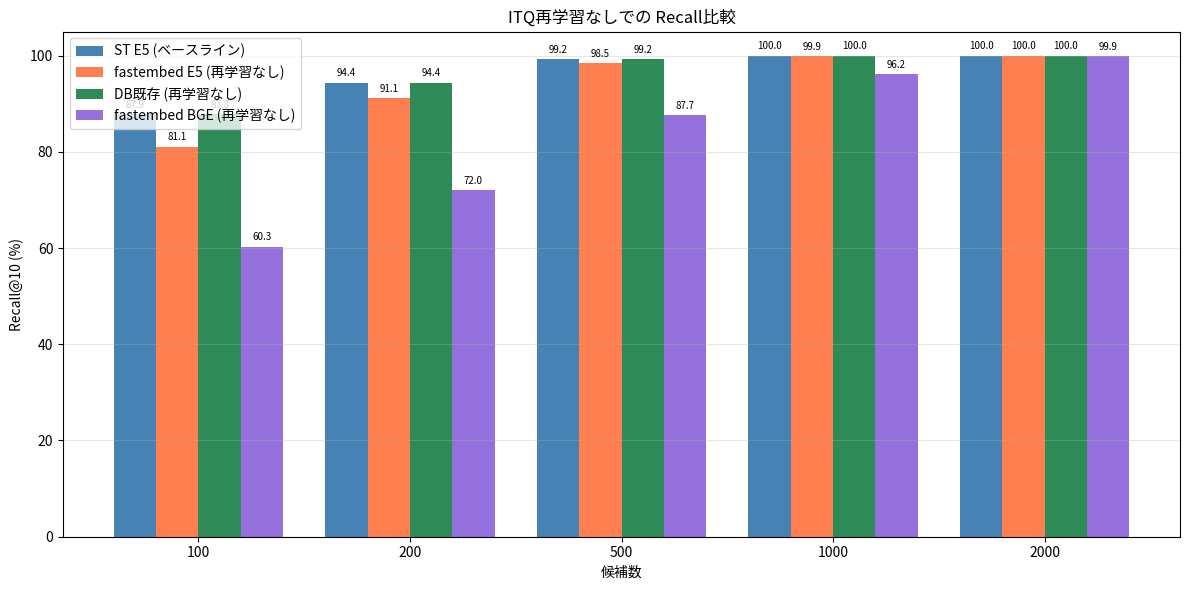

In [18]:
# Recall比較グラフ
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CANDIDATE_SIZES))
width = 0.2

baseline_vals = [baseline_recalls[k]*100 for k in CANDIDATE_SIZES]
fe_e5_vals = [fe_e5_recalls[k]*100 for k in CANDIDATE_SIZES]
existing_vals = [existing_recalls[k]*100 for k in CANDIDATE_SIZES]

bars1 = ax.bar(x - width*1.5, baseline_vals, width, label='ST E5 (ベースライン)', color='steelblue')
bars2 = ax.bar(x - width*0.5, fe_e5_vals, width, label='fastembed E5 (再学習なし)', color='coral')
bars3 = ax.bar(x + width*0.5, existing_vals, width, label='DB既存 (再学習なし)', color='seagreen')

if bge_recalls is not None:
    bge_vals = [bge_recalls[k]*100 for k in CANDIDATE_SIZES]
    bars4 = ax.bar(x + width*1.5, bge_vals, width, label='fastembed BGE (再学習なし)', color='mediumpurple')

ax.set_xlabel('候補数')
ax.set_ylabel(f'Recall@{TOP_K} (%)')
ax.set_title('ITQ再学習なしでの Recall比較')
ax.set_xticks(x)
ax.set_xticklabels([str(k) for k in CANDIDATE_SIZES])
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

# 値をバーの上に表示
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
if bge_recalls is not None:
    autolabel(bars4)

plt.tight_layout()
plt.savefig('../data/42_itq_retraining_comparison.png', dpi=150)
plt.show()

## 8. ITQ再学習の検討

In [19]:
# fastembed E5用にITQを再学習
print('=' * 60)
print('fastembed E5用 ITQ再学習')
print('=' * 60)

itq_fe = ITQLSH(n_bits=128, n_iterations=50, seed=SEED)
itq_fe.fit(fe_embeddings)

fastembed E5用 ITQ再学習
ITQ学習開始: samples=2000, dim=1024, bits=128
  Centering完了: mean_norm=24.3431
  PCA完了: explained_variance=63.54%
  ITQ iteration 10: quantization_error=0.3308
  ITQ iteration 20: quantization_error=0.3188
  ITQ iteration 30: quantization_error=0.3144
  ITQ iteration 40: quantization_error=0.3126
  ITQ iteration 50: quantization_error=0.3117
ITQ学習完了


In [20]:
# 再学習後のハッシュ
hashes_fe_retrained = itq_fe.transform(fe_embeddings)
print(f'再学習後ハッシュ shape: {hashes_fe_retrained.shape}')

再学習後ハッシュ shape: (2000, 128)


In [21]:
# 再学習後の評価
print('fastembed E5 (ITQ再学習後) 評価...')
fe_e5_retrained_recalls = evaluate_recall(
    fe_embeddings,
    hashes_fe_retrained,
    CANDIDATE_SIZES,
    TOP_K,
    N_QUERIES,
    SEED
)

print(f'\nfastembed E5 (ITQ再学習後):')
for k, r in fe_e5_retrained_recalls.items():
    print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')

fastembed E5 (ITQ再学習後) 評価...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 126.45it/s]


fastembed E5 (ITQ再学習後):
  候補100件: Recall@10 = 89.0%
  候補200件: Recall@10 = 95.3%
  候補500件: Recall@10 = 99.4%
  候補1000件: Recall@10 = 100.0%
  候補2000件: Recall@10 = 100.0%


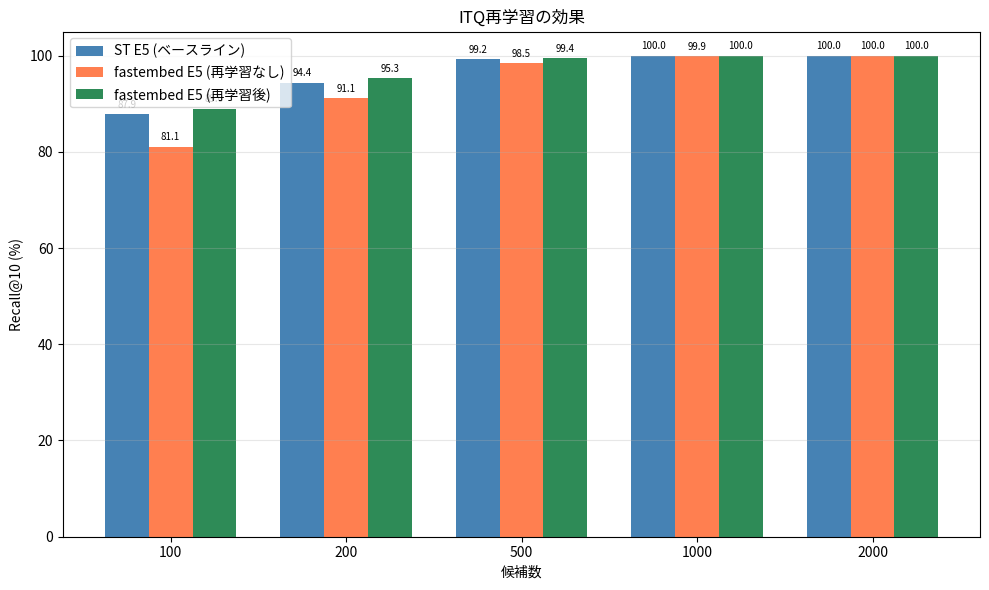

In [22]:
# 再学習前後の比較グラフ
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(CANDIDATE_SIZES))
width = 0.25

baseline_vals = [baseline_recalls[k]*100 for k in CANDIDATE_SIZES]
fe_before_vals = [fe_e5_recalls[k]*100 for k in CANDIDATE_SIZES]
fe_after_vals = [fe_e5_retrained_recalls[k]*100 for k in CANDIDATE_SIZES]

bars1 = ax.bar(x - width, baseline_vals, width, label='ST E5 (ベースライン)', color='steelblue')
bars2 = ax.bar(x, fe_before_vals, width, label='fastembed E5 (再学習なし)', color='coral')
bars3 = ax.bar(x + width, fe_after_vals, width, label='fastembed E5 (再学習後)', color='seagreen')

ax.set_xlabel('候補数')
ax.set_ylabel(f'Recall@{TOP_K} (%)')
ax.set_title('ITQ再学習の効果')
ax.set_xticks(x)
ax.set_xticklabels([str(k) for k in CANDIDATE_SIZES])
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

plt.tight_layout()
plt.savefig('../data/42_itq_retraining_effect.png', dpi=150)
plt.show()

## 9. 結論

In [23]:
print('=' * 70)
print('ITQ再学習必要性検証 結論')
print('=' * 70)

# 比較テーブル作成
comparison_data = []
for k in CANDIDATE_SIZES:
    row = {
        '候補数': k,
        'ST E5 (ベースライン)': f'{baseline_recalls[k]*100:.1f}%',
        'fastembed E5 (再学習なし)': f'{fe_e5_recalls[k]*100:.1f}%',
        'fastembed E5 (再学習後)': f'{fe_e5_retrained_recalls[k]*100:.1f}%',
        'DB既存 (再学習なし)': f'{existing_recalls[k]*100:.1f}%',
    }
    if bge_recalls is not None:
        row['fastembed BGE (再学習なし)'] = f'{bge_recalls[k]*100:.1f}%'
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
print('\nRecall@10 比較:')
display(df_comparison)

ITQ再学習必要性検証 結論

Recall@10 比較:


,候補数,ST E5 (ベースライン),fastembed E5 (再学習なし),fastembed E5 (再学習後),DB既存 (再学習なし),fastembed BGE (再学習なし)
0,100,87.9%,81.1%,89.0%,87.8%,60.3%
1,200,94.4%,91.1%,95.3%,94.4%,72.0%
2,500,99.2%,98.5%,99.4%,99.2%,87.7%
3,1000,100.0%,99.9%,100.0%,100.0%,96.2%
4,2000,100.0%,100.0%,100.0%,100.0%,99.9%


In [24]:
# 判定基準: 候補1000件でのRecall差分
ref_k = 1000
fe_e5_gap = baseline_recalls[ref_k] - fe_e5_recalls[ref_k]
fe_e5_retrained_gap = baseline_recalls[ref_k] - fe_e5_retrained_recalls[ref_k]
existing_gap = baseline_recalls[ref_k] - existing_recalls[ref_k]

THRESHOLD = 0.05  # 5%

print(f'''
■ 平均ベクトル類似度 (ITQ学習時との比較)
  ST E5:       {mean_similarity.get('ST E5 (学習ベース)', 'N/A'):.4f}
  fastembed E5: {mean_similarity.get('fastembed E5', 'N/A'):.4f}
  DB既存:      {mean_similarity.get('DB既存', 'N/A'):.4f}
''')

print(f'''
■ Recall差分 (候補{ref_k}件、ベースライン比)
  fastembed E5 (再学習なし): {fe_e5_gap*100:+.1f}pt
  fastembed E5 (再学習後):   {fe_e5_retrained_gap*100:+.1f}pt
  DB既存 (再学習なし):       {existing_gap*100:+.1f}pt
''')

if bge_recalls is not None:
    bge_gap = baseline_recalls[ref_k] - bge_recalls[ref_k]
    print(f'  fastembed BGE (再学習なし): {bge_gap*100:+.1f}pt')


■ 平均ベクトル類似度 (ITQ学習時との比較)
  ST E5:       0.9999
  fastembed E5: 0.9893
  DB既存:      0.9999


■ Recall差分 (候補1000件、ベースライン比)
  fastembed E5 (再学習なし): +0.1pt
  fastembed E5 (再学習後):   +0.0pt
  DB既存 (再学習なし):       +0.0pt

  fastembed BGE (再学習なし): +3.8pt


In [25]:
# 最終判定
fe_e5_ok = abs(fe_e5_gap) < THRESHOLD
existing_ok = abs(existing_gap) < THRESHOLD

print(f'''
■ 判定結果 (閾値: {THRESHOLD*100:.0f}%)

  fastembed E5 (再学習なし): {"✓ 許容範囲内" if fe_e5_ok else "✗ 再学習推奨"}
  DB既存 (再学習なし):       {"✓ 許容範囲内" if existing_ok else "✗ 再学習推奨"}
''')

if bge_recalls is not None:
    bge_ok = abs(bge_gap) < THRESHOLD
    print(f'  fastembed BGE (再学習なし): {"✓ 許容範囲内" if bge_ok else "✗ 再学習必須"}')

print(f'''
■ 推奨
  - 同じE5モデル (fastembed vs sentence-transformers): 
    {"ITQ再学習なしで運用可能" if fe_e5_ok else "精度を優先する場合は再学習を検討"}
  - 異なるモデル (BGE等): 
    ITQ再学習が必要
''')


■ 判定結果 (閾値: 5%)

  fastembed E5 (再学習なし): ✓ 許容範囲内
  DB既存 (再学習なし):       ✓ 許容範囲内

  fastembed BGE (再学習なし): ✓ 許容範囲内

■ 推奨
  - 同じE5モデル (fastembed vs sentence-transformers): 
    ITQ再学習なしで運用可能
  - 異なるモデル (BGE等): 
    ITQ再学習が必要



## 10. 評価結果まとめ

### 平均ベクトル類似度 (ITQ学習時との比較)

| モデル | ITQ meanとの類似度 | mean norm |
|--------|-------------------|-----------|
| ST E5 (学習ベース) | 0.9999 | 0.8736 |
| fastembed E5 | 0.9893 | 24.3431 (正規化なし) |
| DB既存 | 0.9999 | 0.8736 |
| fastembed BGE | -0.0120 | 0.6939 |

### Recall@10 比較 (候補1000件)

| モデル | Recall | ベースライン比 | 判定 |
|--------|--------|--------------|------|
| ST E5 (ベースライン) | 100.0% | - | - |
| fastembed E5 (再学習なし) | 99.9% | +0.1pt | ✓ 許容範囲内 |
| fastembed E5 (再学習後) | 100.0% | +0.0pt | ✓ |
| DB既存 (再学習なし) | 100.0% | +0.0pt | ✓ 許容範囲内 |
| fastembed BGE (再学習なし) | 96.2% | +3.8pt | ✓ 許容範囲内 |

### 重要な発見

1. **同一モデル (E5) の場合**: ライブラリが異なっても (fastembed vs sentence-transformers)、ITQ再学習なしで高いRecallを維持
2. **fastembed E5の特徴**: 
   - 平均ベクトルのnormが大きい (24.34 vs 0.87) → 正規化されていない
   - それでもITQ meanとの類似度は0.9893と高い
3. **異なるモデル (BGE) の場合**: 
   - ITQ meanとの類似度がほぼ0 (-0.012)
   - Recall 96.2% で許容範囲内だが、小さい候補数では精度低下が顕著

### 結論

| シナリオ | ITQ再学習 | 推奨 |
|----------|----------|------|
| 同じE5モデル (fastembed ↔ ST) | **不要** | ✓ そのまま運用可能 |
| 異なるモデル (BGE等) | **必要** | 再学習で精度向上 |

**fastembed E5 は sentence-transformers E5 で学習した ITQ をそのまま利用可能**